In [6]:
import os
import pandas as pd

FOLDER_AI = {"ai", "fake", "fakev2", "synthetic", "generated"}
FOLDER_REAL = {"real", "human", "original"}
IMAGE_EXTENSIONS = {".jpg", ".jpeg", ".png", ".webp"}

records = []

# ---------- PASS 1: Folder-based datasets ----------
for root, _, files in os.walk("/kaggle/input"):
    # ❗ skip CSV-based dataset completely here
    if "ai-vs-human-generated-dataset" in root:
        continue

    leaf = os.path.basename(root).lower()

    if leaf not in FOLDER_AI and leaf not in FOLDER_REAL:
        continue

    label = 1 if leaf in FOLDER_AI else 0

    for f in files:
        if os.path.splitext(f)[1].lower() in IMAGE_EXTENSIONS:
            records.append({
                "path": os.path.join(root, f),
                "label": label
            })

# ---------- PASS 2: CSV-based dataset ----------
CSV_ROOT = "/kaggle/input/ai-vs-human-generated-dataset"

def load_csv_dataset(csv_path):
    df = pd.read_csv(csv_path)

    for _, row in df.iterrows():
        img_path = os.path.join(CSV_ROOT, row["file_name"])
        label = int(row["label"])  # 0 = Real, 1 = AI

        if os.path.exists(img_path):
            records.append({
                "path": img_path,
                "label": label
            })

load_csv_dataset(f"{CSV_ROOT}/train.csv")

# ---------- FINAL DATAFRAME ----------
df = pd.DataFrame(records)

print("Total images:", len(df))
print(df["label"].value_counts())

df.to_csv("/kaggle/working/dataset_index_clean.csv", index=False)


Total images: 86933
label
0    45957
1    40976
Name: count, dtype: int64


In [7]:
print(df["label"].value_counts())

label
0    45957
1    40976
Name: count, dtype: int64


In [9]:
df = pd.read_csv("/kaggle/working/dataset_index_clean.csv")

MAX_FILE_SIZE = 15 * 1024 * 1024  # 15 MB

safe_rows = []

for _, row in df.iterrows():
    try:
        if os.path.getsize(row["path"]) <= MAX_FILE_SIZE:
            safe_rows.append(row)
    except:
        pass

safe_df = pd.DataFrame(safe_rows)

print("Original images:", len(df))
print("Safe images    :", len(safe_df))
print("Removed        :", len(df) - len(safe_df))

safe_df.to_csv("/kaggle/working/dataset_index_safe.csv", index=False)


Original images: 86933
Safe images    : 86928
Removed        : 5


In [10]:
df = pd.read_csv("/kaggle/working/dataset_index_safe.csv")

train_df, temp_df = train_test_split(
    df, test_size=0.2, stratify=df["label"], random_state=42
)

val_df, test_df = train_test_split(
    temp_df, test_size=0.5, stratify=temp_df["label"], random_state=42
)

print("Train:", len(train_df))
print("Val  :", len(val_df))
print("Test :", len(test_df))


Train: 69542
Val  : 8693
Test : 8693


In [11]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

def load_image(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

def make_dataset(df, shuffle=False):
    ds = tf.data.Dataset.from_tensor_slices(
        (df["path"].values, df["label"].values)
    )

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

train_ds = make_dataset(train_df, shuffle=True)
val_ds   = make_dataset(val_df)
test_ds  = make_dataset(test_df)


I0000 00:00:1768233571.028784      55 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [12]:
model = models.Sequential([
    layers.Conv2D(32, 3, activation="relu", input_shape=(224,224,3)),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation="relu"),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(1, activation="sigmoid")
])

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [14]:
EPOCHS = 5

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[TqdmCallback(verbose=1)]
)


0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

Epoch 1/5


I0000 00:00:1768233574.644496     140 service.cc:152] XLA service 0x7b51380048f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1768233574.644535     140 service.cc:160]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1768233575.157516     140 cuda_dnn.cc:529] Loaded cuDNN version 91002


   5/2174 ━━━━━━━━━━━━━━━━━━━━ 1:07 31ms/step - accuracy: 0.4227 - loss: 1.1125

I0000 00:00:1768233580.274016     140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 206s 91ms/step - accuracy: 0.8626 - loss: 0.3458 - val_accuracy: 0.9412 - val_loss: 0.1547
Epoch 2/5
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.9331 - loss: 0.1866 - val_accuracy: 0.9489 - val_loss: 0.1508
Epoch 3/5
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 101s 46ms/step - accuracy: 0.9450 - loss: 0.1505 - val_accuracy: 0.9519 - val_loss: 0.1329
Epoch 4/5
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 101s 47ms/step - accuracy: 0.9527 - loss: 0.1310 - val_accuracy: 0.9542 - val_loss: 0.1282
Epoch 5/5
2174/2174 ━━━━━━━━━━━━━━━━━━━━ 102s 47ms/step - accuracy: 0.9616 - loss: 0.1034 - val_accuracy: 0.9593 - val_loss: 0.1309


In [15]:
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [16]:
test_loss, test_acc = model.evaluate(test_ds)
print("✅ Test Accuracy:", test_acc)


272/272 ━━━━━━━━━━━━━━━━━━━━ 22s 78ms/step - accuracy: 0.9554 - loss: 0.1460
✅ Test Accuracy: 0.9598527550697327


In [17]:
model.save("/kaggle/working/ai_vs_real_cnn.keras")


In [18]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    preds = (preds > 0.5).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)


Confusion Matrix:
 [[4454  142]
 [ 207 3890]]


In [19]:
print(classification_report(
    y_true, y_pred,
    target_names=["Real", "AI"]
))


              precision    recall  f1-score   support

        Real       0.96      0.97      0.96      4596
          AI       0.96      0.95      0.96      4097

    accuracy                           0.96      8693
   macro avg       0.96      0.96      0.96      8693
weighted avg       0.96      0.96      0.96      8693



In [20]:
from sklearn.metrics import roc_auc_score

y_scores = []

for images, _ in test_ds:
    scores = model.predict(images, verbose=0).flatten()
    y_scores.extend(scores)

auc = roc_auc_score(y_true, y_scores)
print("ROC-AUC:", auc)


ROC-AUC: 0.9917795249363083


In [21]:
for t in [0.3, 0.5, 0.7]:
    preds = (np.array(y_scores) > t).astype(int)
    acc = (preds == np.array(y_true)).mean()
    print(f"Threshold {t}: Accuracy {acc:.4f}")


Threshold 0.3: Accuracy 0.9588
Threshold 0.5: Accuracy 0.9599
Threshold 0.7: Accuracy 0.9569


In [22]:
shuffled_df = train_df.copy()
shuffled_df["label"] = np.random.permutation(shuffled_df["label"].values)

shuffled_ds = make_dataset(shuffled_df, shuffle=True)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.fit(shuffled_ds, epochs=1)


2174/2174 ━━━━━━━━━━━━━━━━━━━━ 96s 43ms/step - accuracy: 0.5274 - loss: 0.8201


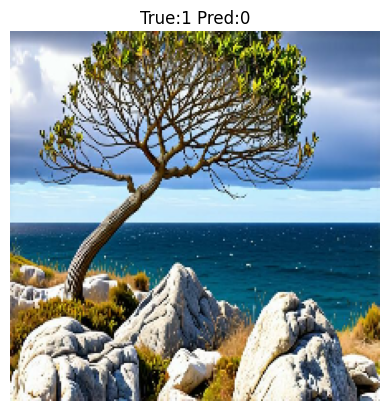

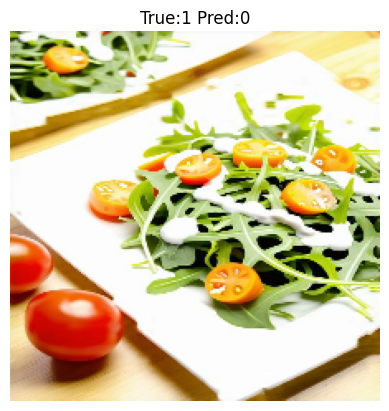

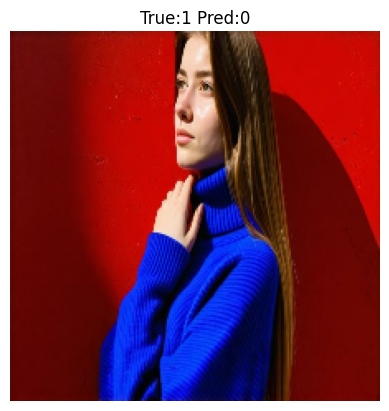

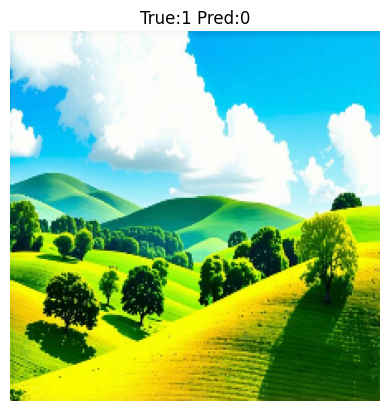

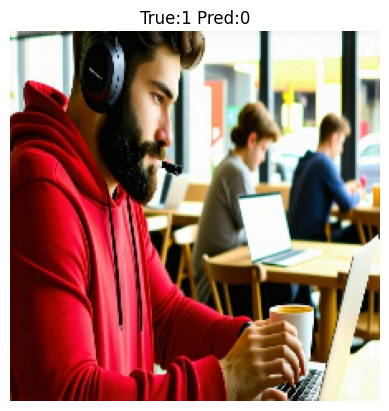

In [23]:
import matplotlib.pyplot as plt

wrong = []

for images, labels in test_ds:
    preds = (model.predict(images, verbose=0) > 0.5).astype(int).flatten()
    for img, y, p in zip(images, labels, preds):
        if y != p:
            wrong.append((img.numpy(), y, p))
        if len(wrong) >= 5:
            break
    if len(wrong) >= 5:
        break

for img, y, p in wrong:
    plt.imshow(img)
    plt.title(f"True:{y} Pred:{p}")
    plt.axis("off")
    plt.show()
